# Common imports

In [30]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


# Provided functions
### Image loading and saving

In [31]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [32]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [33]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [34]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [35]:
def show_img(img):
    plt.imshow(img)
    plt.show()


In [36]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    result = np.zeros(imarray.shape, dtype=np.float64)
    print(imarray.shape)
    
    result = np.subtract(imarray.astype(np.float64), ambient_image.astype(np.float64)[:, :, np.newaxis])
        
    result[result < 0] = 0
    
    result /= result.max()
    # print(result)
    return result

In [37]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    
    h, w, n = imarray.shape
    print("h,w,n=")
    print(imarray.shape)
    pixel_per_image = h * w
    temp_normals = np.zeros((3, pixel_per_image))
    tmp_albedo = np.zeros((1, pixel_per_image))
    pixel_values = np.zeros((n, pixel_per_image))
    # change  to 64 * pixel_numbers
    
    for i in range(n):
        pixel_values[i] = np.reshape(imarray[:, :, i], -1)
    # lights.shape is 64*3
    # shape of G is  3 * pixel_numbers 
    # lights_dirs * G = pixel_values
    
    print(pixel_values.shape)
    g = np.linalg.lstsq(light_dirs, pixel_values)
    g_matrix = np.array(g[0])
    
    # print("g_matrix.shape:")
    # print(g_matrix.shape)
    # print("g is :")
    # print(g_matrix)
    # print("g ends")
    
    # now albedo is 1 * pixel value
    for i in range(pixel_per_image):
        tmp_albedo[:, i] = np.linalg.norm(g_matrix[:, i])
        temp_normals[:, i] = np.true_divide(g_matrix[:, i], tmp_albedo[:, i])
    
    picture_shape = (h, w)
    albedo_image = np.reshape(tmp_albedo, picture_shape)
    temp_normals = np.reshape(temp_normals, (3, h, w))
    surface_normals = np.stack(temp_normals, axis=2)
    
    # print("surface normals")
    # print(surface_normals)
    # print("surface normals ends")
  
    return albedo_image, surface_normals

In [ ]:
def row_integration(f_x,f_y):
    # x = np.cumsum(f_x,1)
    # y = np.cumsum(f_x[:, 0]).reshape()
    
    temp = np.copy(f_y)
    temp[0, 1:] = np.cumsum(f_x[0, 1:])
    temp[0][0] = 0
    # 0 is vertical
    height_map = np.cumsum(temp, axis=0)
    return height_map

    
def column_integration(f_x,f_y):
    temp = np.copy(f_x)
    temp[1:, 0] = np.cumsum(f_y[1:, 0])
    temp[0][0] = 0
    # 1 is horizontal
    height_map = np.cumsum(temp, axis=1)

    return height_map

    
def average_integration(f_x,f_y):
    # first row then cols
    temp1 = np.copy(f_y)
    temp1[0, 1:] = np.cumsum(f_x[0, 1:])
    temp1[0, 0] = 0
    height_map1 = np.cumsum(temp1, axis=0)
    
    # first col, then row
    temp2 = np.copy(f_x)
    temp2[1:, 0] = np.cumsum(f_y[1:, 0])
    temp2[0, 0] = 0
    height_map2 = np.cumsum(temp2, axis=1)
    
    height_map = (height_map1 + height_map2) * 0.5
    
    return height_map 
    
    
def random_integration(f_x, f_y):
    height, width = f_x.shape
    path_number = 25
    height_map = np.zeros((f_x.shape))
    
    # if dir == 1, then integrate Y dir
    # else integrate X dir
    for row in range(height):
        for col in range(width):
            dirs = np.zeros(row+col)
            for i in range(row):
                dirs[i] = 1
            for _ in range(0, path_number):
                np.random.shuffle(dirs)
                current_sum = f_x[0][0] + f_y[0][0]
                x = y = 0
                for dir in dirs:
                    if dir == 1:
                        y += 1
                        current_sum += f_y[y][x]
                    else:
                        x += 1
                        current_sum += f_x[y][x]
                height_map[row][col] += current_sum
            height_map[row][col] /= n
    return height_map                        
                        

def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    h, w, _ = surface_normals.shape
    height_map = np.zeros((h, w))
    
    n_x = surface_normals[:, :, 0]
    n_y = surface_normals[:, :, 1]
    n_z = surface_normals[:, :, 2]
    
    # compute the derivative. shape: h * w
    f_x = np.true_divide(n_x, n_z) 
    f_y = np.true_divide(n_y, n_z)
    
    
    switcher = {
        'column': column_integration,
        'row': row_integration,
        'average': average_integration,
        'random': random_integration
    }
    func = switcher.get(integration_method)
    return func(f_x, f_y)

# Main function

showing ambient image:


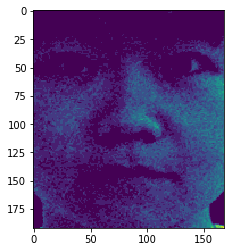

(192, 168, 64)
h,w,n=
(192, 168, 64)


(64, 32256)


C:\Users\liuzhe\mp0\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


height_map generated


In [53]:
root_path = 'croppedyale/'
subject_name = 'yaleB05'
integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)
print("showing ambient image:")
show_img(ambient_image)
processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, 'random')
print("height_map generated")
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

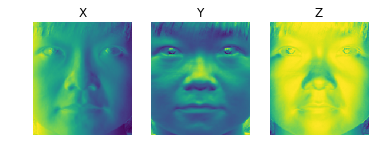

In [54]:
plot_surface_normals(surface_normals)

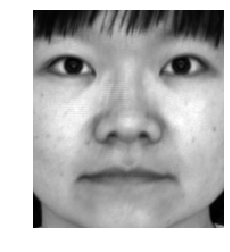

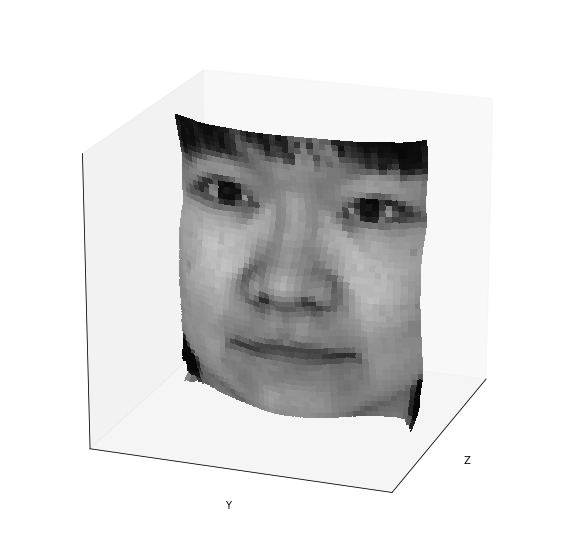

In [55]:
display_output(albedo_image, height_map)